# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

**Install scnet using pip**

**It may be necessary to restart (not delete) the runtime after installing scNET in Google Colab. We are working on fixing this issue in future releases.**

In [ ]:
!pip install scnet

**Download example data**

In [1]:
import gdown
download_url = f'https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi'
output_path = './example.h5ad'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi
From (redirected): https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi&confirm=t&uuid=2122b26b-2850-43d5-9c49-aeadc5b8945d
To: /content/example.h5ad
100%|██████████| 1.36G/1.36G [00:16<00:00, 82.2MB/s]


'./example.h5ad'

# Import scNET and model traning

In [2]:
import scNET
import scanpy as sc

#For faster processing in medium to large datasets (e.g. 30K or above cells), the maximum cells batch size can be increased depending on the available GPU memory.

#For GPU with 24GB memory
scNET.main.MAX_CELLS_BATCH_SIZE = 3000

#for GPU with 40GB memory
scNET.main.MAX_CELLS_BATCH_SIZE = 4000

#For GPU with 80GB memory or more
scNET.main.MAX_CELLS_BATCH_SIZE = 8000

#otherwize, do not change the default value

In [ ]:
#To control the cutoff of gene expression, the minimum precetage of cells expressing a gene can be adjusted. The default all expressed genes are considered.
#For example, to consider genes expressed in at least 5% of cells
#scNET.main.EXPRESSION_CUTOFF = 0.05

In [ ]:
scNET.main.NUM_LAYERS = 3

In [ ]:
#To control the number of deifferentially expressed genes
#For example, to consider 3500 DE genes
#For larger dataset (15K or above), containing larger number of subcommunities, use 5000 - 7000. You may consider 10000 for 50K cells and above.
scNET.main.DE_GENES_NUM = 3500


## run_scNET arguments:
 **obj (AnnData, optional):** AnnData obj.

  **pre_processing_flag (bool, optional):** If True, perform pre-processing steps.

  **human_flag (bool, optional):** Controls gene name casing in the network.

  **number_of_batches (int, optional):** Number of mini-batches for the training.

  **split_cells (bool, optional):** If True, split by cells instead of edges during training. If using A100 could be True (for 10K cells or less)

  **n_neighbors (int, optional):** Number of neighbors for building the adjacency graph.

  **max_epoch (int, optional):** Max number of epochs for model training (recommended 250-300, and for larger dataset consider also 300-350).

  **model_name (str, optional):** Identifier for saving the model outputs.
  
  **save_model_flag (bool, optional):** If True, save the trained model.

In [22]:
obj = sc.read_h5ad("./example.h5ad")
scNET.run_scNET(obj, pre_processing_flag=False, human_flag=False, number_of_batches=10, split_cells=True, max_epoch=300, model_name = "test")


/usr/local/lib/python3.12/dist-packages/scNET/Data/format_h_sapiens.csv
N genes: (11049, 9019)
Highly variable genes: 3000


Training: 100%|██████████| 300/300 [1:27:00<00:00, 17.40s/it]

Best Network AUC: 0.8908586223122029



# Using the model's outputs

**Load all the relevant embeddings**


In [25]:
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("test")

**Create Scanpy object based on the reconstructed gene expression**


In [ ]:
cell_types = {"0":"Macrophages","1":"Macrophages","2":"CD8 Tcells","3":"Microglia","4":"Cancer","5":"CD4 Tcells","6":"B Cells","10":"Prolifrating Tcells","8":"Cancer","11":"NK"}
obj.obs["Cell Type"] = obj.obs.seurat_clusters.map(cell_types)
recon_obj = scNET.create_reconstructed_obj(node_features, out_features, obj)

**Plot marker genes**

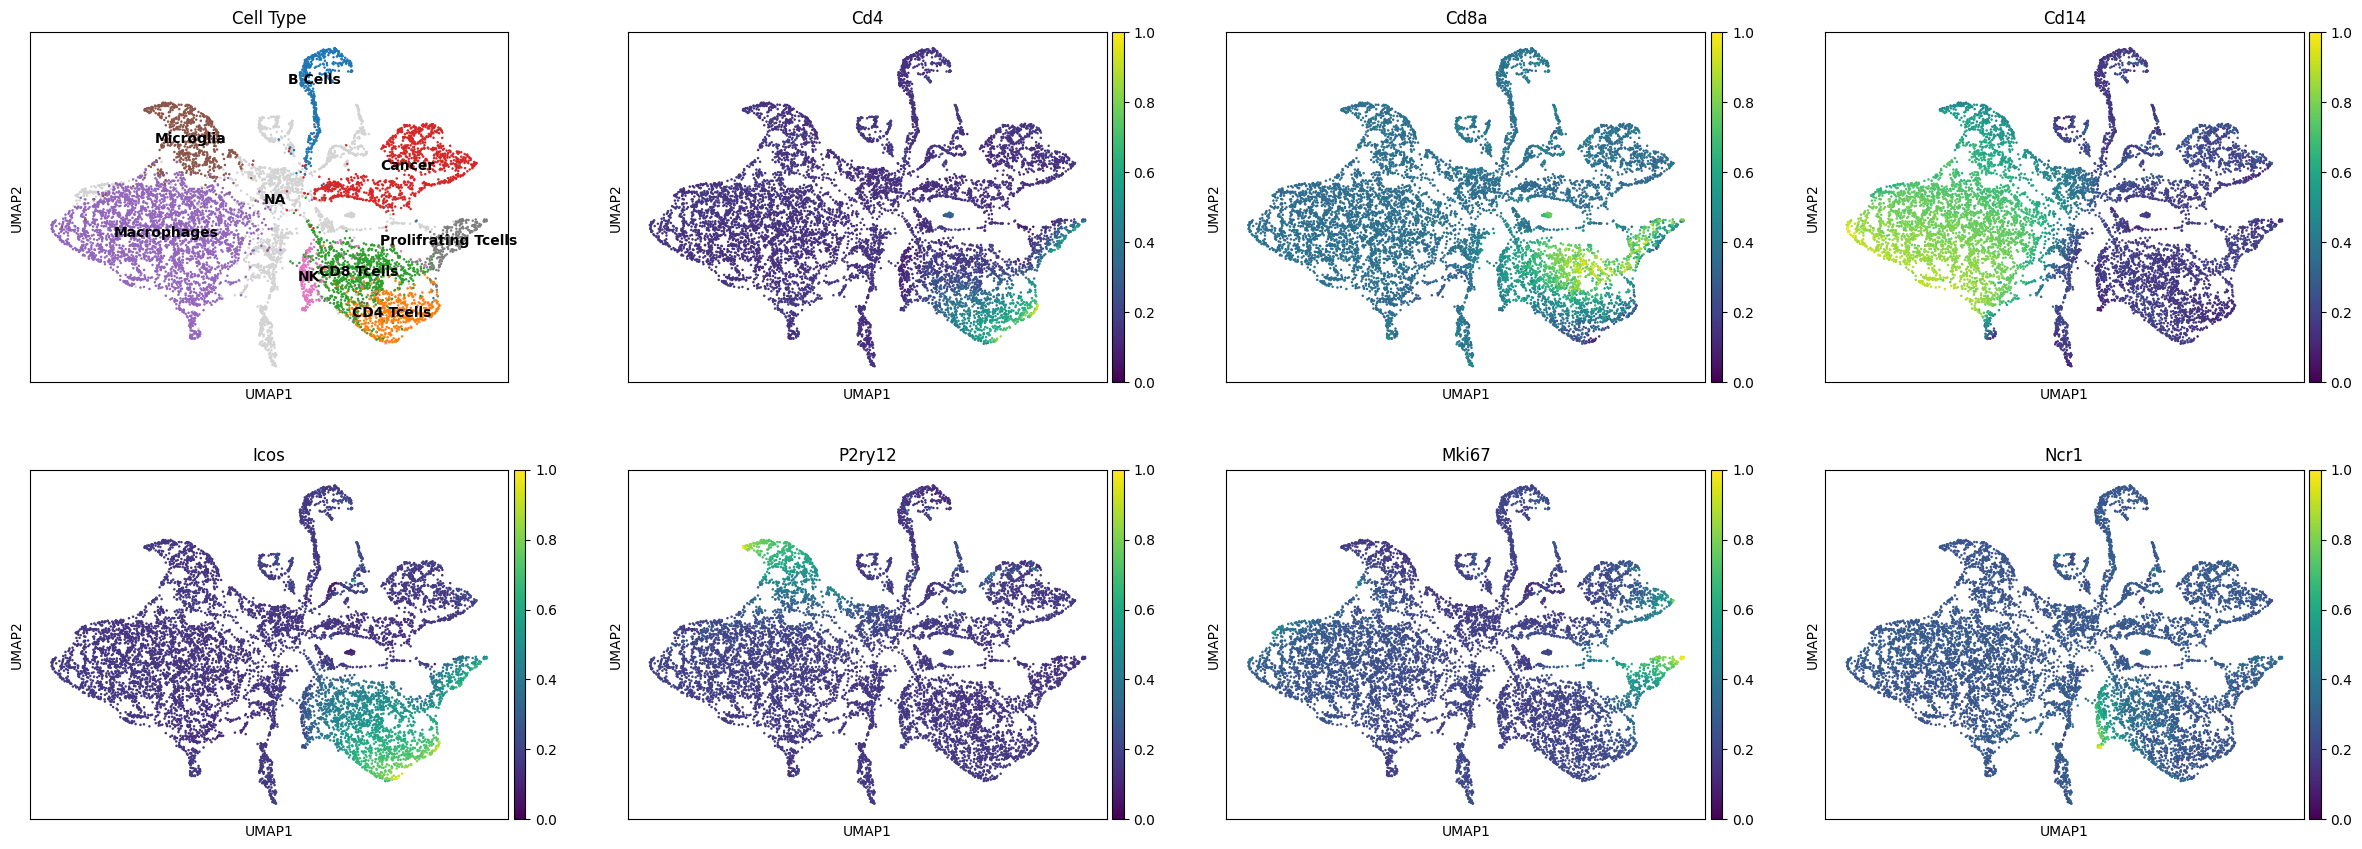

In [ ]:
sc.pl.umap(recon_obj, color=["Cell Type","Cd4","Cd8a","Cd14","Icos","P2ry12","Mki67","Ncr1"], show=True, legend_loc='on data')

**Example of Calculating Marker Gene AUPR**

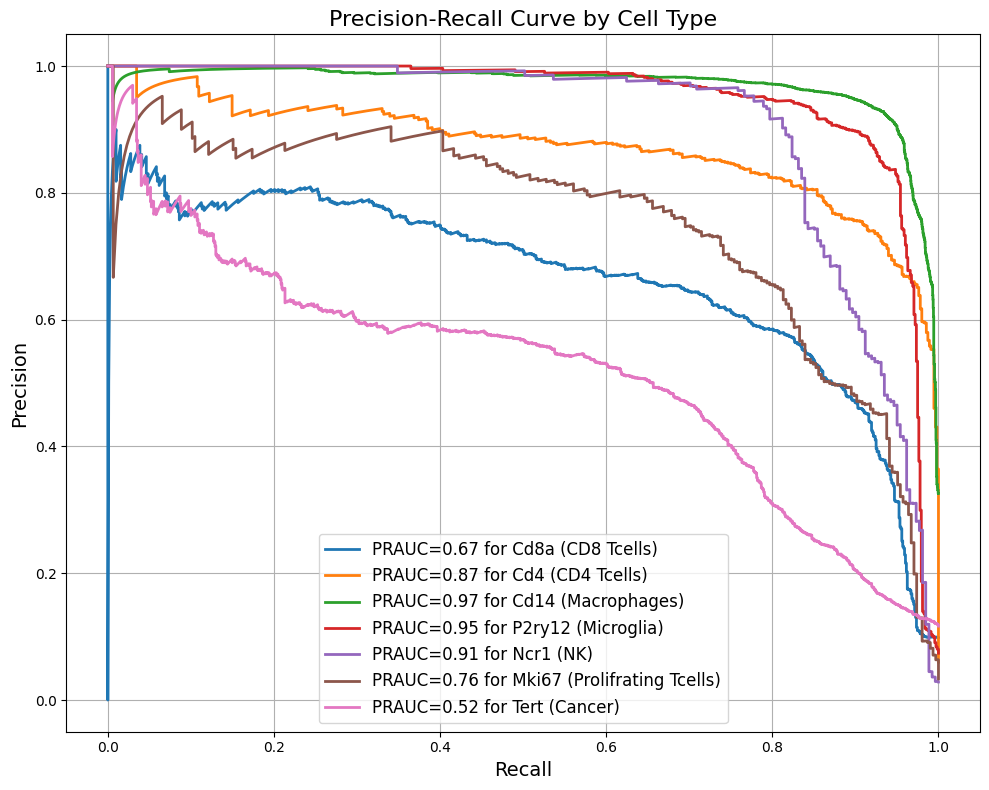

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from itertools import cycle

def calculate_marker_gene_aupr(adata, marker_genes, cell_types):
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
    plt.figure(figsize=(10, 8))

    for marker_gene, cell_type, color in zip(marker_genes, cell_types, colors):
        gene_expression = adata[:, marker_gene].X.toarray().flatten()
        binary_labels = (adata.obs["Cell Type"].isin(cell_type)).astype(int)

        precision, recall, _ = precision_recall_curve(binary_labels, gene_expression)
        aupr = auc(recall, precision)
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'PRAUC={aupr:.2f} for {marker_gene} ({cell_type[0]})')

    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve by Cell Type', fontsize=16)
    plt.legend(loc="best", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
calculate_marker_gene_aupr(recon_obj,['Cd8a','Cd4','Cd14',"P2ry12","Ncr1","Mki67","Tert"],[["CD8 Tcells"],['CD4 Tcells'], ['Macrophages'], ['Microglia'], ["NK"],["Prolifrating Tcells"],["Cancer"]])




## GO Semantic Similarity

Download the Semantic Similarity table calculated using the GoSemSim package in R.



In [ ]:
import gdown
download_url = f'https://drive.google.com/uc?id=1glnzD-rFk_zzBVF7tDmjTP-HmhqKEPVU'
output_path = './sim.csv'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1glnzD-rFk_zzBVF7tDmjTP-HmhqKEPVU
From (redirected): https://drive.google.com/uc?id=1glnzD-rFk_zzBVF7tDmjTP-HmhqKEPVU&confirm=t&uuid=0ce8c98c-3b1a-40d8-9c6c-8b5db3b6f92c
To: /content/sim.csv
100%|██████████| 868M/868M [00:12<00:00, 71.0MB/s]


'./sim.csv'

Filter out uninformative genes

In [ ]:
import pandas as pd
import numpy as np
sim = pd.read_csv("./sim.csv", index_col=0)
fil = (sim == 1).sum() > 4000
sim = sim.loc[~fil,~fil]
sim

,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,...,MATN4,SRMS,IGLV11-55,RASL10A,RBFOX2,SLC16A8,TAFA5,MIOX,TREX2,AVPR2
NOC2L,1.000,0.230,0.287,0.270,0.232,0.276,0.232,0.339,0.156,0.145,...,0.206,0.236,0.169,0.354,0.334,0.019,0.199,0.087,0.347,0.280
KLHL17,0.230,1.000,0.112,0.074,0.183,0.367,0.191,0.124,0.267,0.086,...,0.334,0.227,0.116,0.156,0.199,0.051,0.171,0.090,0.124,0.171
PLEKHN1,0.287,0.112,1.000,0.200,0.185,0.179,0.253,0.285,0.115,0.149,...,0.078,0.169,0.165,0.196,0.273,0.035,0.170,0.120,0.272,0.165
HES4,0.270,0.074,0.200,1.000,0.137,0.227,0.138,0.329,0.128,0.205,...,0.057,0.130,0.138,0.118,0.436,0.031,0.110,0.104,0.413,0.147
ISG15,0.232,0.183,0.185,0.137,1.000,0.284,0.256,0.271,0.126,0.170,...,0.178,0.456,0.226,0.645,0.233,0.030,0.192,0.255,0.429,0.316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC16A8,0.019,0.051,0.035,0.031,0.030,0.036,0.042,0.041,0.073,0.021,...,0.030,0.031,0.074,0.035,0.031,1.000,0.036,0.016,0.027,0.037
TAFA5,0.199,0.171,0.170,0.110,0.192,0.312,0.486,0.151,0.122,0.062,...,0.137,0.314,0.148,0.736,0.305,0.036,1.000,0.083,0.113,0.431
MIOX,0.087,0.090,0.120,0.104,0.255,0.101,0.101,0.108,0.078,0.145,...,0.062,0.155,0.105,0.069,0.194,0.016,0.083,1.000,0.215,0.097
TREX2,0.347,0.124,0.272,0.413,0.429,0.364,0.209,0.426,0.114,0.351,...,0.092,0.382,0.231,0.098,0.791,0.027,0.113,0.215,1.000,0.207


Find the intersection between the genes in the similarity matrix and the genes in the embedding, reconstructed gene expression, or counts matrix.



In [ ]:
row_embedding_df = pd.DataFrame(embedded_genes, index=list(map(lambda x: x.upper(), node_features.index)))
inter = row_embedding_df.index.intersection(sim.index)
row_embedding_df = row_embedding_df.loc[inter]
sim = sim.loc[inter,inter]
row_embedding_df

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
ABL1,-0.810310,-0.378325,0.058025,-0.086489,-0.111574,0.402983,-0.039701,0.556663,0.301640,-0.363090,...,-0.232179,0.336882,-0.301830,-0.146817,0.027433,-0.199244,0.004408,0.102099,-0.429024,0.373999
CDKN1A,-0.408017,-0.375731,-0.174682,0.108766,0.150977,0.109286,-0.062012,0.252083,0.487460,0.315487,...,-0.303459,0.127870,0.045181,0.199486,-0.245171,-0.187047,0.345570,0.431940,-0.181506,0.463974
PARP1,-0.552987,-0.425340,-0.197280,0.090663,0.304135,0.136155,-0.397672,0.297880,0.743314,0.434807,...,-0.296966,0.000953,0.010815,0.127247,-0.291978,-0.355992,0.594260,0.336095,-0.490220,0.602991
AKT1,-0.951054,-0.622797,-0.287534,-0.003542,-0.329757,0.414288,0.176138,0.795981,0.521405,0.009829,...,-0.566941,0.406203,-0.108683,0.267183,-0.236428,-0.355323,-0.015675,0.612314,-0.327586,0.796188
APP,4.852540,2.148647,1.500857,-2.090061,0.723504,-0.768978,2.944792,-0.691961,-0.116655,-2.918601,...,-0.078143,2.943800,-3.577324,0.054319,-0.085235,-2.390529,2.679632,-1.699546,-4.957414,2.306935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DPM3,-0.148312,-0.080373,-0.061375,0.089919,-0.119334,-0.068969,-0.057799,0.030108,-0.007950,-0.013877,...,0.092856,0.042588,0.069504,0.009497,0.078161,0.085856,-0.103175,-0.042839,-0.082746,-0.068660
DPM2,-0.149656,-0.074698,-0.081160,0.083835,-0.120278,-0.154014,-0.050187,-0.037708,-0.028900,0.114192,...,0.139859,-0.000424,0.108284,0.068235,0.124409,0.160634,-0.166899,-0.122057,0.029965,-0.192208
BORCS7,-0.061236,-0.019469,-0.023298,0.133293,-0.021393,-0.147295,-0.061456,-0.005785,-0.084214,0.157163,...,0.046081,-0.077226,0.033905,0.139432,0.081065,0.149938,-0.126763,-0.098812,0.174803,-0.205552
KDM7A,-0.149551,-0.026487,-0.147774,0.119396,-0.148619,-0.085583,0.062899,-0.031368,-0.070334,0.089352,...,0.117633,0.024679,0.248403,0.050476,0.042876,0.087471,-0.122724,-0.181285,-0.163939,-0.048276


In [ ]:
out_features_df = pd.DataFrame(out_features.T, index=list(map(lambda x: x.upper(), node_features.index)))
out_features_df = out_features_df.loc[inter]
out_features_df

,0,1,2,3,4,5,6,7,8,9,...,9000,9001,9002,9003,9004,9005,9006,9007,9008,9009
ABL1,0.448745,0.542257,0.324248,0.344193,0.241387,0.273808,0.259261,0.409482,0.135410,0.136210,...,0.222469,0.356130,0.145280,0.409988,-0.091983,0.271595,0.500429,-0.080443,0.152255,0.142320
CDKN1A,0.099310,0.233070,0.056305,0.089865,0.178493,0.122254,0.165604,0.087144,0.153354,0.095016,...,0.163034,0.199085,0.130843,0.026933,-0.084669,0.002452,0.169799,-0.062157,0.163536,0.176544
PARP1,0.265215,-0.022329,0.290691,0.274762,0.014607,-0.046946,-0.013167,0.294457,0.046879,0.036715,...,0.051607,0.112085,0.006860,0.123609,-0.199508,0.043349,0.302699,-0.176682,0.011423,0.024262
AKT1,0.346636,0.451027,0.378415,0.395248,0.218728,0.234689,0.245335,0.442032,0.156044,0.135100,...,0.215594,0.377403,0.136503,0.343574,-0.160695,0.230307,0.423040,-0.143838,0.170374,0.168371
APP,0.400554,0.462859,0.274332,0.361013,0.238047,-0.104560,0.043506,0.315125,0.130389,0.168531,...,0.241812,0.224469,0.180747,0.196900,-0.104433,0.106540,0.411122,-0.078987,0.114041,0.163302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DPM3,-0.025258,-0.005958,-0.007805,0.038404,-0.067587,-0.102409,-0.068242,-0.017204,-0.037133,-0.026493,...,-0.077604,-0.060758,-0.058512,-0.081462,-0.068219,-0.007215,-0.002744,-0.045104,-0.049314,-0.054368
DPM2,-0.183330,-0.150652,-0.158878,-0.181042,-0.120291,-0.063505,-0.075251,-0.189530,-0.067437,-0.079726,...,-0.131419,-0.155344,-0.075983,-0.137131,0.012108,-0.048147,-0.206247,0.024518,-0.058533,-0.078916
BORCS7,-0.048409,-0.032672,0.014528,0.007774,0.002509,0.003581,-0.004852,0.000919,0.035811,0.037861,...,0.019837,0.014001,0.025836,-0.089758,0.013103,-0.071215,-0.021764,0.023642,0.021493,0.037597
KDM7A,-0.221616,-0.181441,-0.143915,-0.213464,0.002103,0.033444,0.053818,-0.172579,-0.020602,-0.052767,...,-0.044820,-0.019450,-0.030554,-0.082976,0.046826,-0.036846,-0.247560,0.032473,0.021602,-0.012500


In [ ]:
node_features_df = pd.DataFrame(node_features.values, index=list(map(lambda x: x.upper(), node_features.index)))
node_features_df = node_features_df.loc[inter]
node_features_df

,0,1,2,3,4,5,6,7,8,9,...,9009,9010,9011,9012,9013,9014,9015,9016,9017,9018
ABL1,0.631628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.896135,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.59506,0.000000,0.000000,0.000000,0.000000
CDKN1A,0.000000,2.513924,2.294897,0.000000,2.806467,1.902295,0.876684,0.000000,2.344279,0.483211,...,3.217964,0.000000,2.900149,0.0,2.315192,0.00000,2.505024,2.728701,0.700835,1.359743
PARP1,0.631628,0.000000,0.421933,0.000000,0.396074,0.000000,0.000000,0.987792,0.000000,0.807611,...,0.559209,0.845701,1.043937,0.0,0.000000,0.59506,0.000000,0.000000,0.000000,0.000000
AKT1,0.000000,0.000000,0.421933,0.000000,0.000000,1.486310,0.876684,0.445817,0.545261,0.483211,...,0.915721,0.845701,0.000000,0.0,0.924713,0.00000,0.000000,0.951786,0.700835,0.544530
APP,0.000000,3.165755,1.287726,0.877381,1.768115,0.760923,1.888837,1.595818,1.677162,1.786777,...,1.177998,0.000000,2.047441,0.0,1.396811,0.00000,0.877750,1.752844,0.700835,2.986629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DPM3,0.000000,0.000000,0.717749,0.000000,0.396074,0.760923,1.336536,1.177751,0.545261,0.483211,...,0.915721,0.845701,0.800619,0.0,1.716215,0.00000,0.877750,0.951786,0.000000,0.000000
DPM2,1.015716,0.000000,0.000000,0.000000,0.396074,0.000000,0.000000,0.445817,0.000000,0.483211,...,0.000000,0.000000,0.000000,0.0,0.924713,0.00000,0.000000,0.951786,0.700835,0.895107
BORCS7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.483211,...,0.000000,0.000000,0.800619,0.0,0.000000,0.00000,0.000000,0.000000,0.700835,0.544530
KDM7A,0.000000,0.000000,0.000000,0.000000,0.000000,1.486310,1.888837,0.000000,0.000000,0.483211,...,0.559209,1.297250,0.800619,0.0,0.000000,0.59506,0.000000,0.000000,0.000000,0.000000


Calculating the semantic similarity correlation

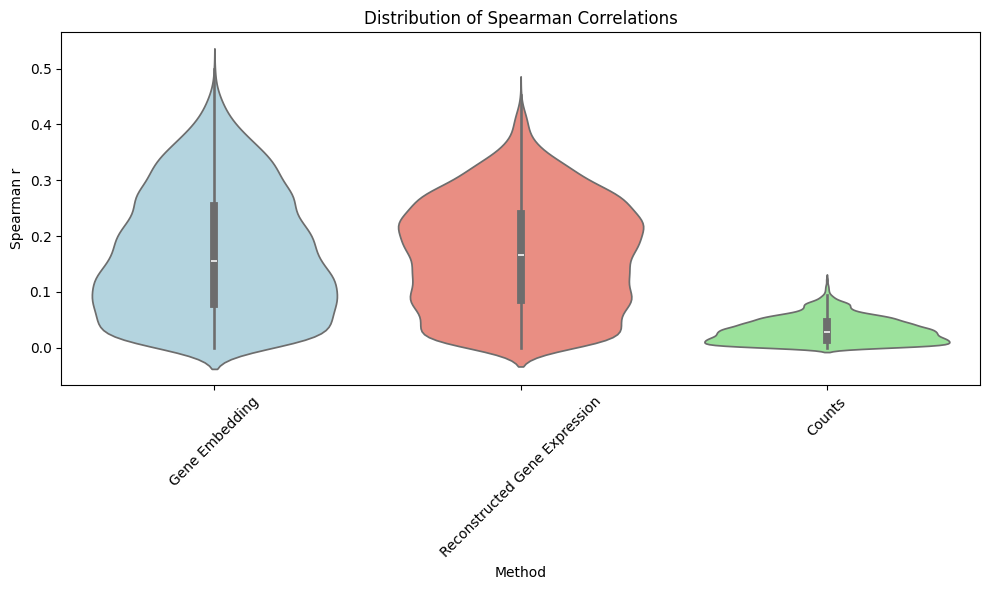

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata, spearmanr

def spearman_corr(matrix):
    ranked_matrix = np.apply_along_axis(rankdata, 1, matrix)
    return np.corrcoef(ranked_matrix)

def corr_analysis(corr, sim):
    sim_values = sim.values
    correlations = np.empty(sim.shape[0])
    for i in range(sim.shape[0]):
        correlations[i], _ = spearmanr(corr[i], sim_values[i])
    return np.abs(correlations)

def plot_corr_distributions(corr_matrices, names, sim):
    all_data = []

    for matrix, name in zip(corr_matrices, names):
        #corr = spearman_corr(matrix)
        corr = matrix.values @ matrix.T.values
        abs_corrs = corr_analysis(corr, sim)
        all_data.extend([(name, val) for val in abs_corrs])

    df = pd.DataFrame(all_data, columns=["Method","Correlation"])

    custom_palette = {
        names[0]: "lightblue",
        names[1]: "salmon",
        names[2]: "lightgreen"
    }

    plt.figure(figsize=(10, 6))
    sns.violinplot(x="Method", y="Correlation", data=df, palette=custom_palette)
    plt.title("Distribution of Spearman Correlations")
    plt.ylabel("Spearman r")
    plt.xlabel("Method")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_corr_distributions([row_embedding_df,out_features_df, node_features_df], names=["Gene Embedding","Reconstructed Gene Expression", "Counts"], sim=sim)

## **Propagation based signature projection for actvation of Tcells**



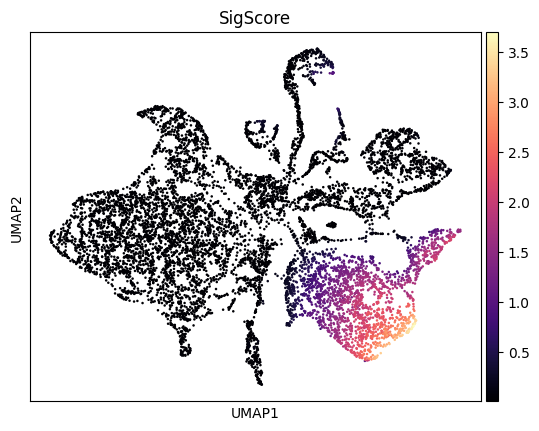

array([1.4109436 , 0.12715845, 0.00765445, ..., 1.6398329 , 0.02568626,
       0.29754505])

In [ ]:
scNET.run_signature(recon_obj, up_sig=["Zap70","Lck","Fyn","Cd3g","Cd28","Lat"],alpha = 0.9)

**And for Tumor aggression**

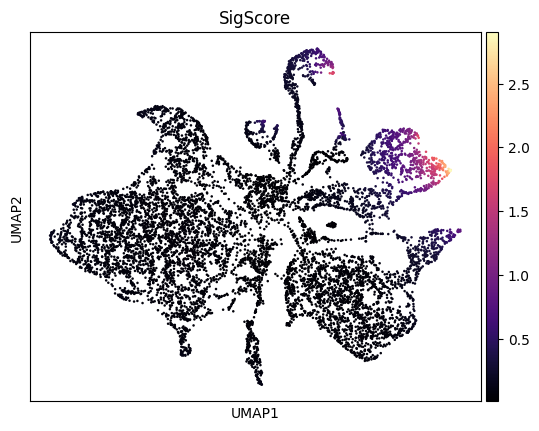

array([0.20527067, 0.60530215, 0.44784426, ..., 0.34722397, 0.0442711 ,
       1.02327249])

In [ ]:

scNET.run_signature(recon_obj,up_sig=["Cdkn2a","Myc","Pten","Kras"])


**Creating the co-embedded network, is it modular?**

In [ ]:
import networkx as nx
net, mod = scNET.build_co_embeded_network(embedded_genes, node_features)
print(f"The network mdularity: {mod}")

##  Reconstract KEGG Pathways Example



### Re-embed the T-cells subset

In [36]:
obj = sc.read_h5ad("./example.h5ad")
sub_obj = obj[obj.obs["Cell Type"] == "CD8 Tcells"]
scNET.run_scNET(sub_obj, pre_processing_flag=False, human_flag=False, number_of_batches=3, split_cells=False, max_epoch=300, model_name = "Tcells")
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("Tcells")

/usr/local/lib/python3.12/dist-packages/scNET/Data/format_h_sapiens.csv
N genes: (9522, 753)


Training: 100%|██████████| 300/300 [20:27<00:00,  4.09s/it]

Best Network AUC: 0.8852655358249608


In [37]:
from scNET import coEmbeddedNetwork  as cen
import pandas as pd
def run_pathway_recon_anaylsis(gene_embedding, ref, threshold=40):
    '''
    Predicts KEGG pathway memberships using gene embeddings and reference data, and evaluates the performance using AUPR.

    Args:
        gene_embedding (np.ndarray): The matrix of gene embeddings.
        ref (pd.DataFrame): A reference dataset containing gene expression or other relevant features.

    Returns:
        pd.DataFrame: A DataFrame containing the AUPR scores for predictions from the gene embeddings and reference data.

    Method:
        - Annotates genes with KEGG pathway memberships using `crate_kegg_annot`.
        - Filters KEGG pathways to include those with at least 40 gene members.
        - Constructs co-embedded networks from both the embeddings and reference data.
        - Uses propagation to predict pathway memberships for each graph.
        - Evaluates the predictions using AUPR and plots the results.
    '''
    ref.index = list(map(lambda x: x.upper(),ref.index))
    annot = cen.crate_kegg_annot(ref.index)
    annot_threshold = annot.sum()>=threshold
    annot_threshold = annot_threshold[annot_threshold == True].sort_values(ascending=False).head(50)
    graph_embedded,_ = cen.build_co_embeded_network(gene_embedding,ref)
    graph_ref,_ = cen.build_co_embeded_network(ref,ref)
    kegg_pred = [cen.make_term_predication([graph_embedded,graph_ref], annot[term]) for term in annot_threshold.index]

    kegg_pred = np.array(kegg_pred).squeeze()
    df = pd.DataFrame({"AUPR" : kegg_pred.T.reshape(-1), "Method": ["scNET" for i in range(kegg_pred.shape[0])]  +  ["Counts" for i in range(kegg_pred.shape[0])]})

    fig, ax = plt.subplots(figsize=[10,7])
    fig.set_dpi(600)

    custom_palette =  ['darkturquoise', 'lightsalmon']

    sns.boxenplot(ax=ax, data=df,x="Method", y="AUPR", palette=custom_palette)
    sns.set_theme(style='white',font_scale=1.5)
    plt.show()

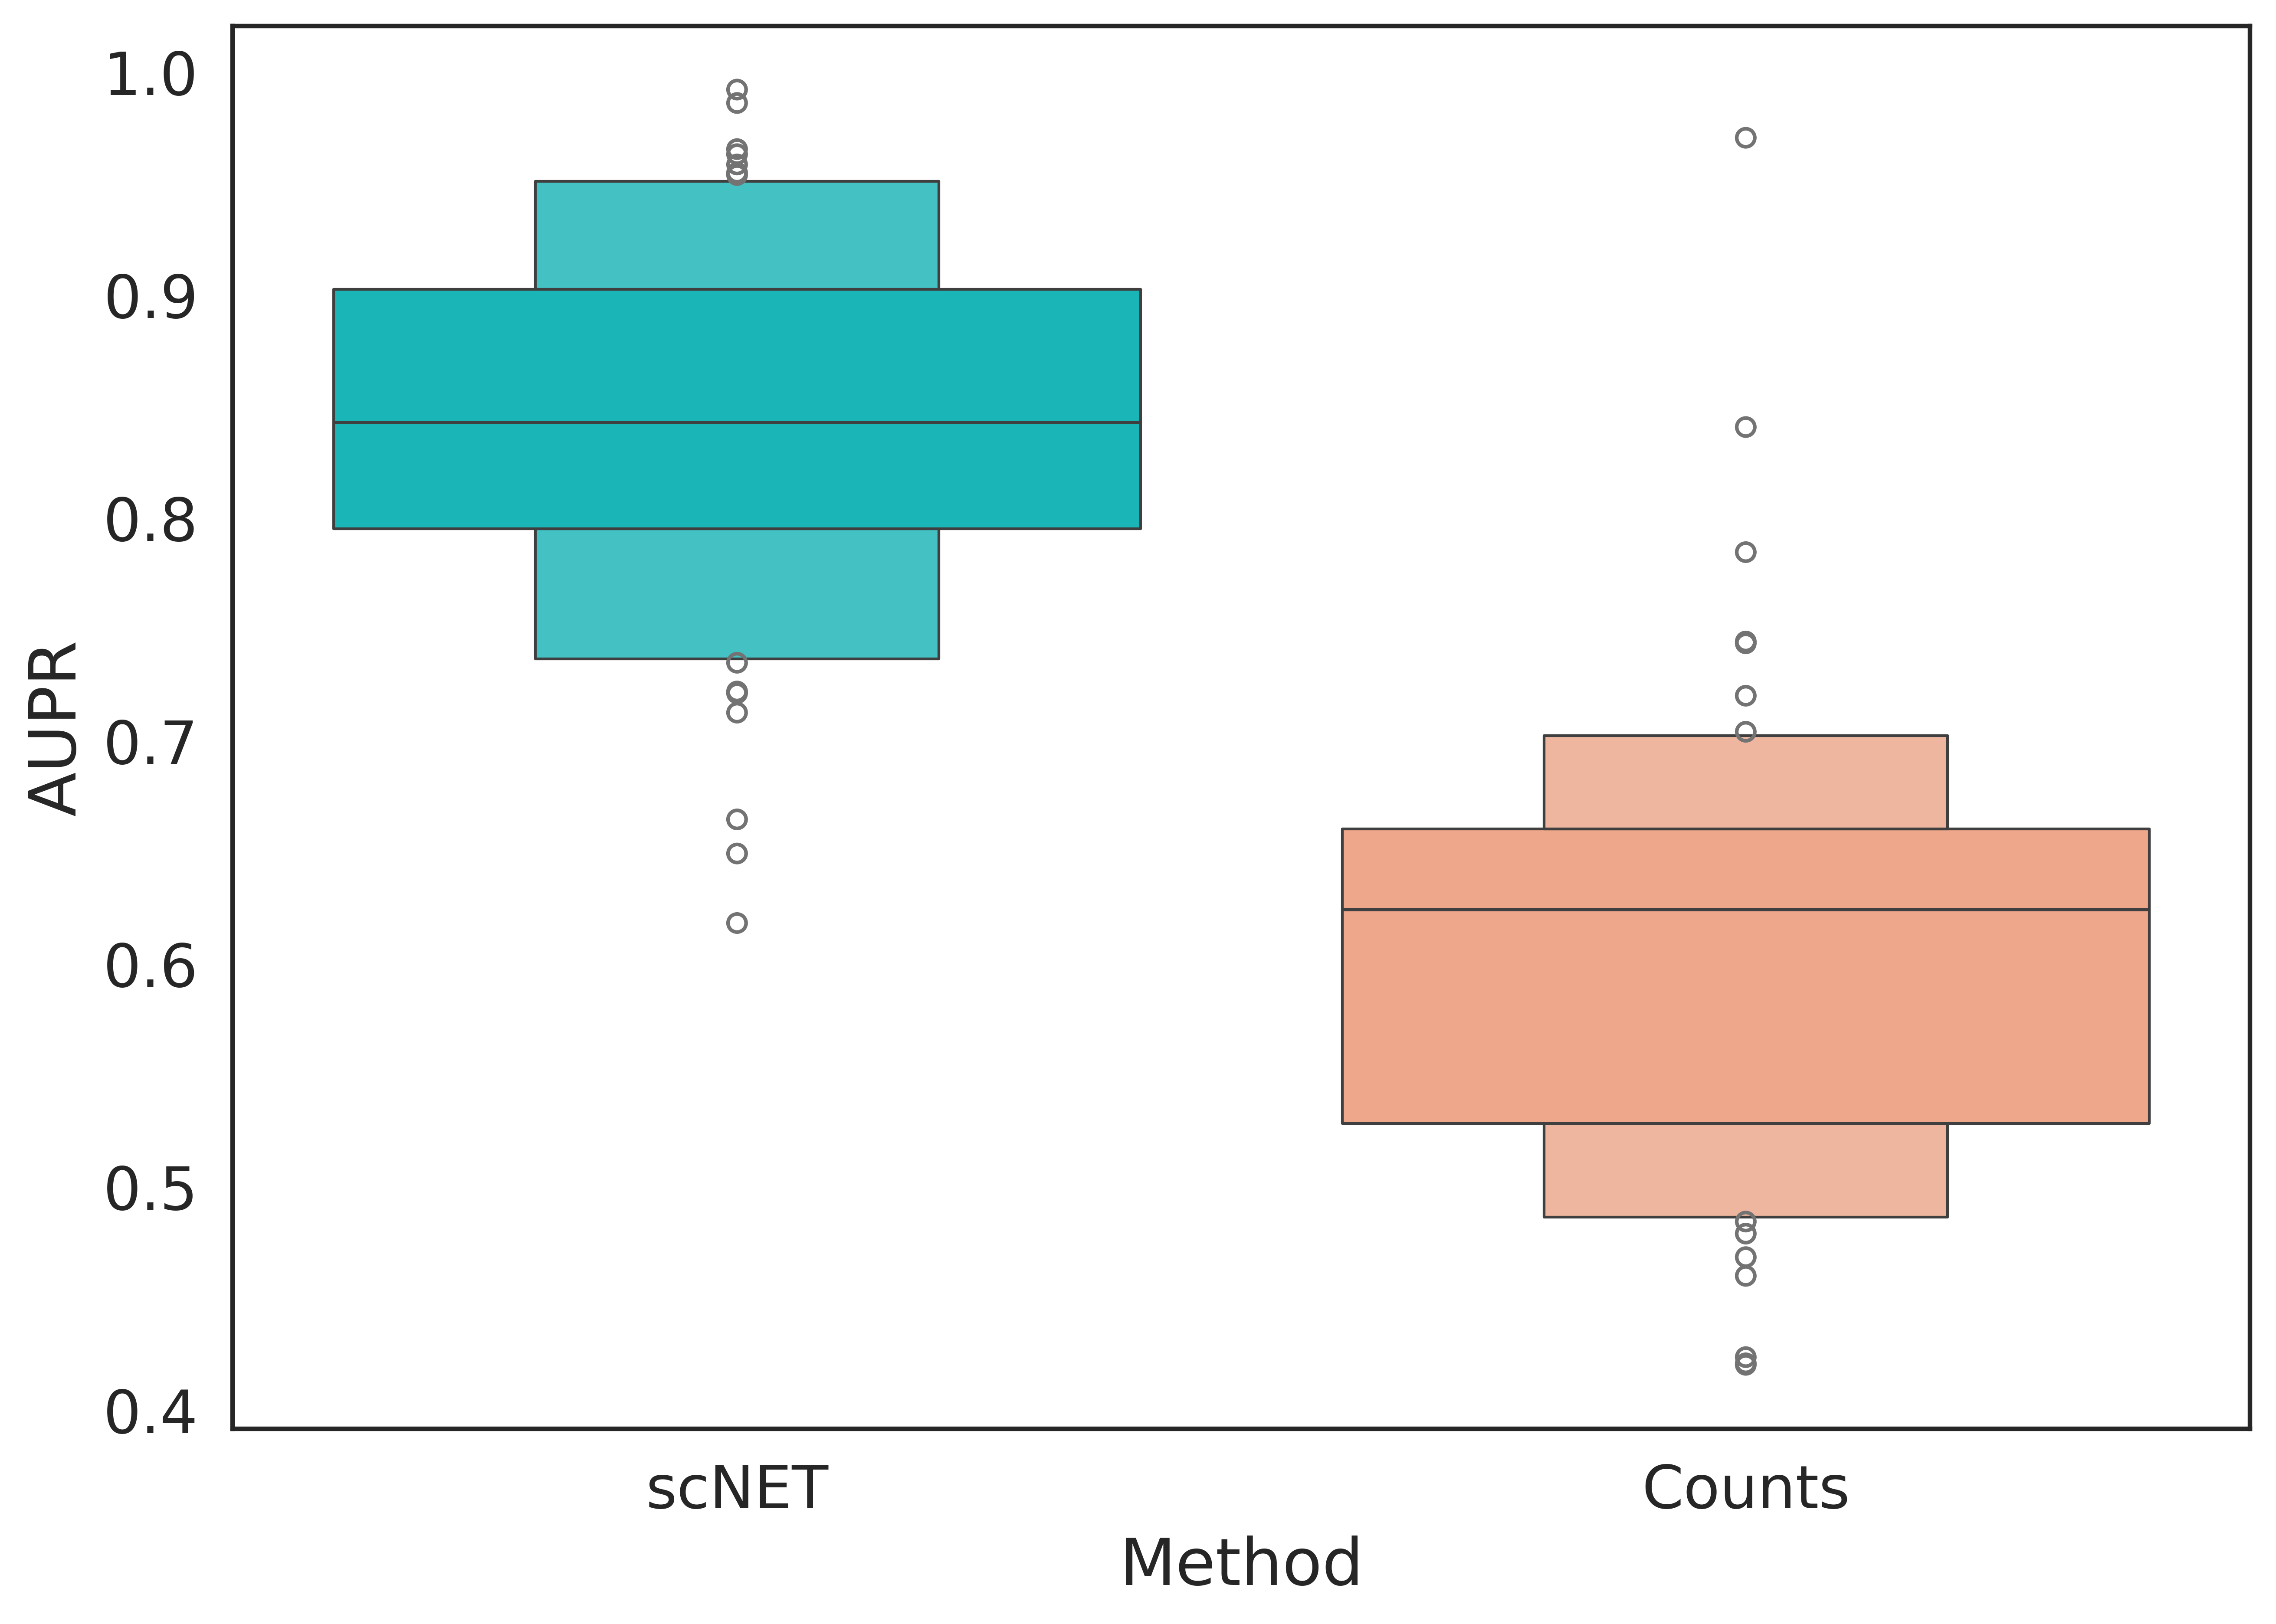

In [ ]:

run_pathway_recon_anaylsis(embedded_genes,node_features)

**Finding differential enriched pathways**
### Can we see a difference in phenotype between Cancer, Microglia and Macrophages?








<Figure size 1000x3000 with 0 Axes>

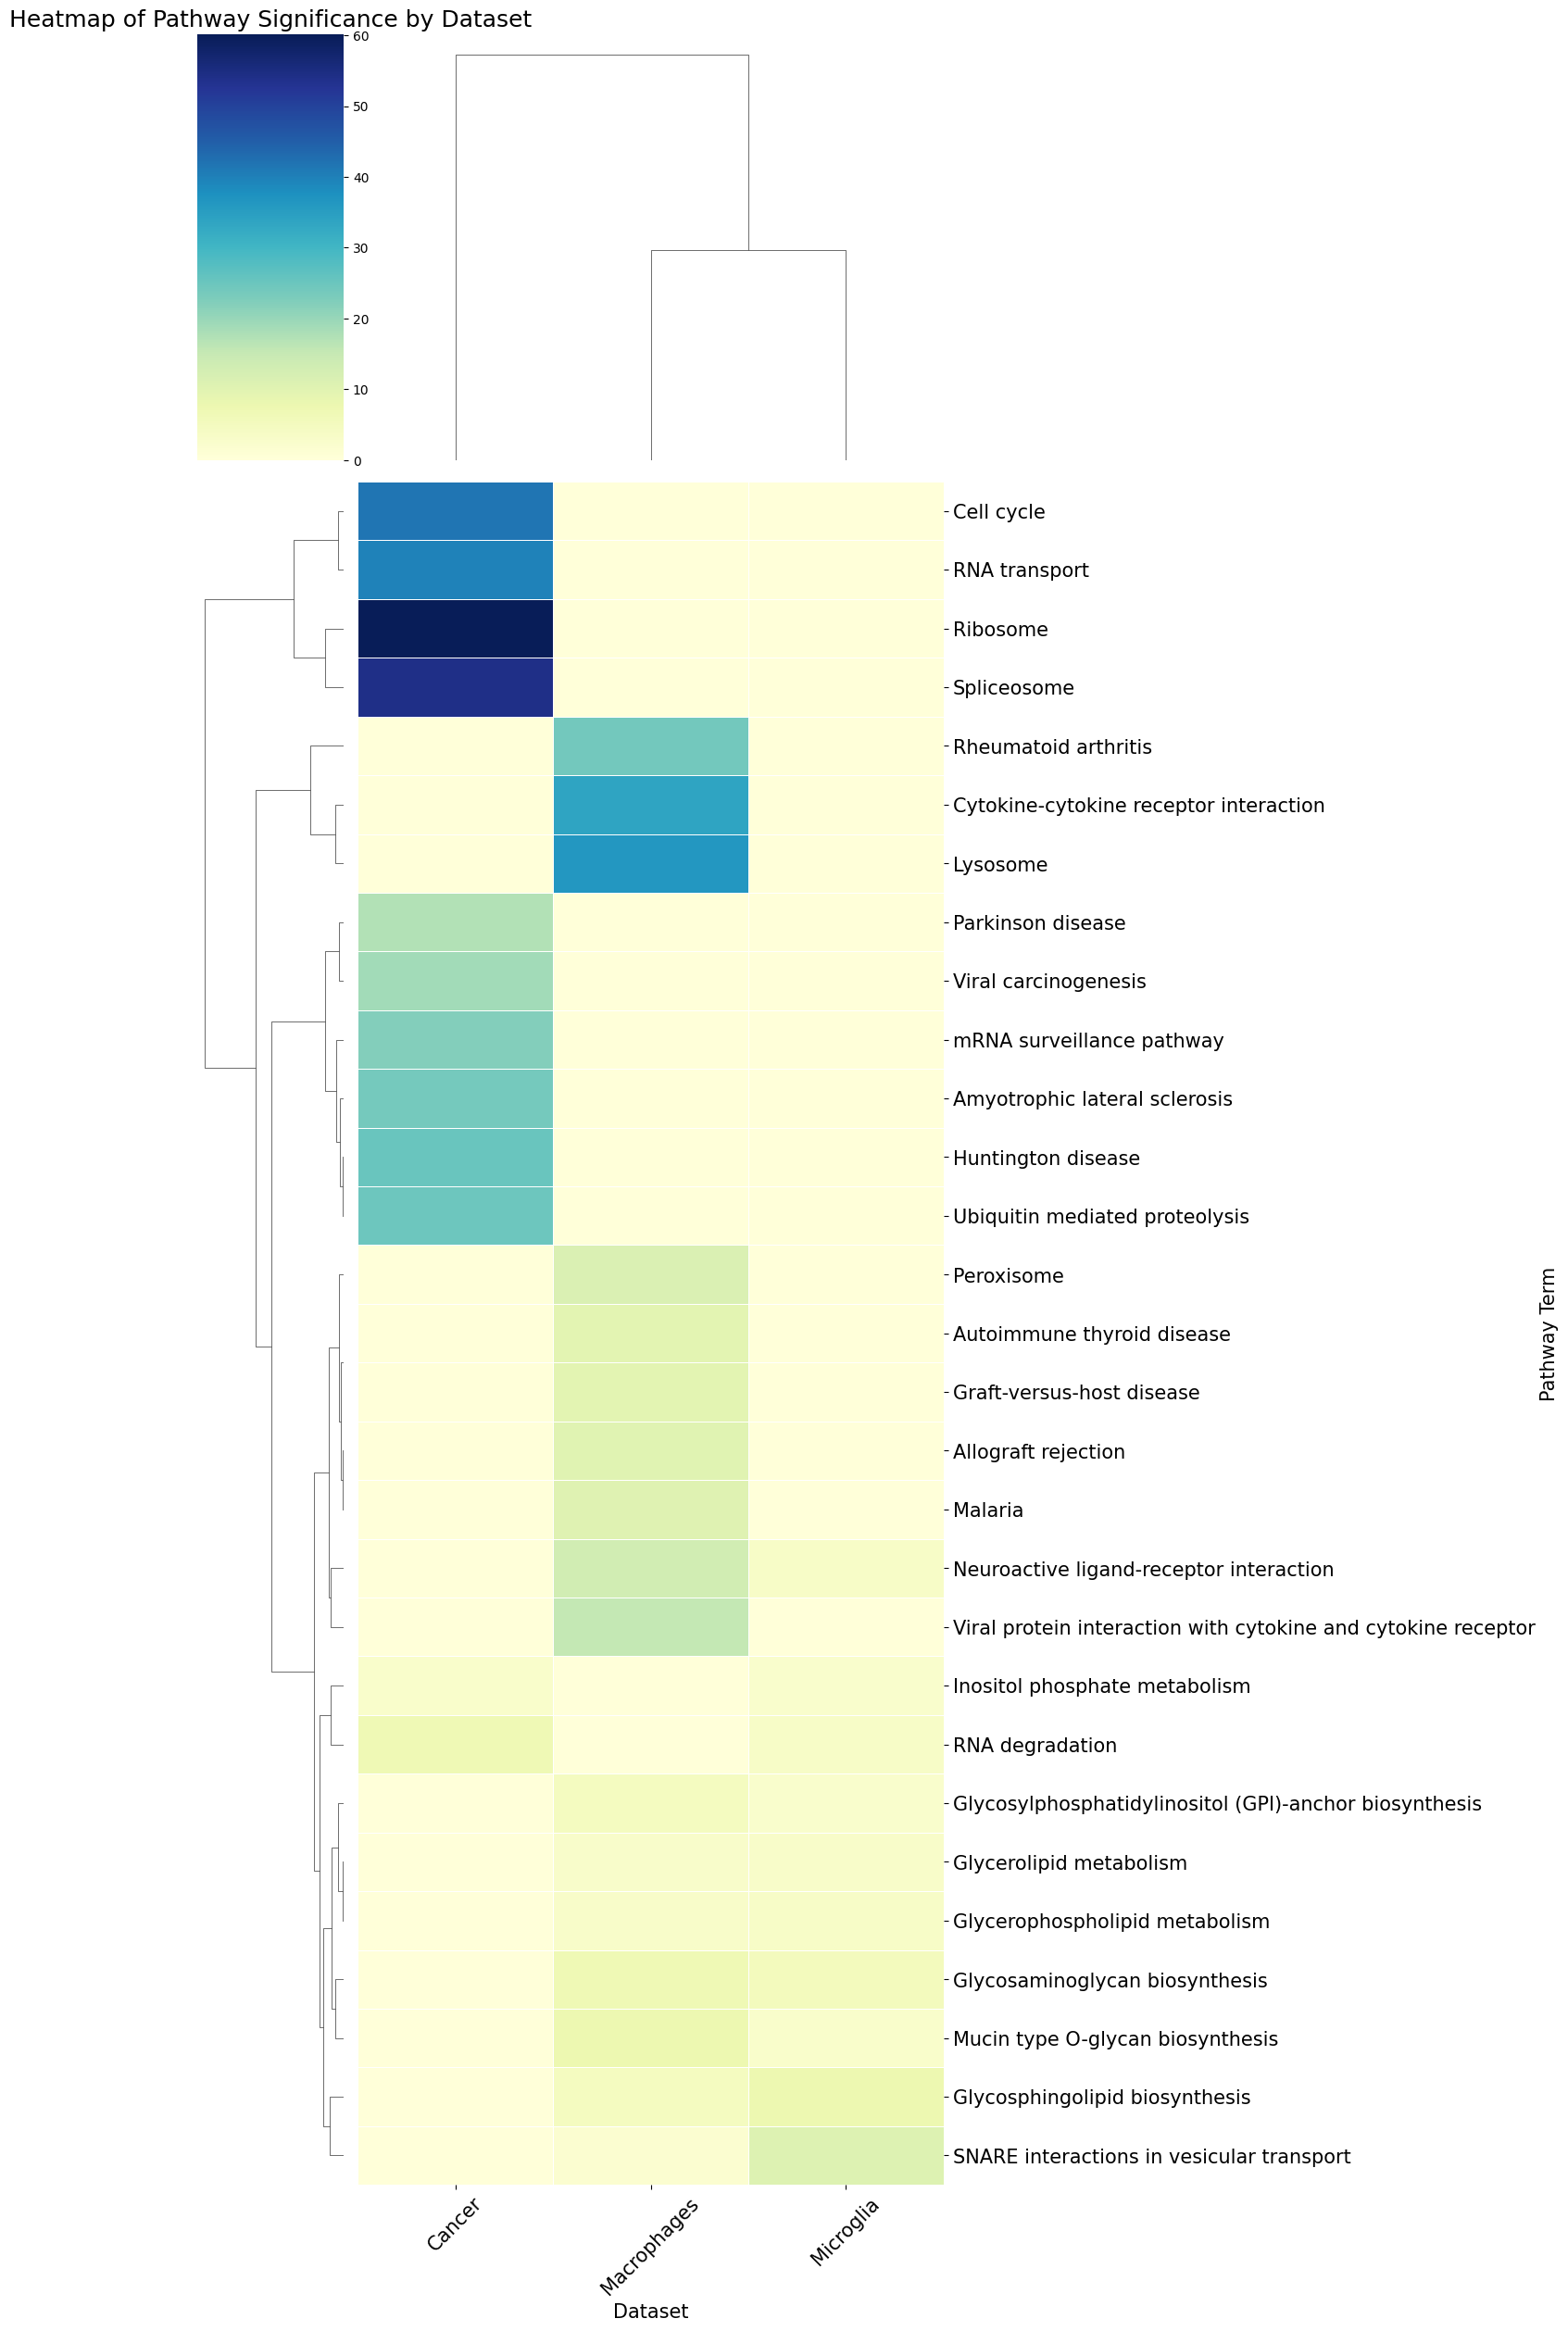

In [ ]:
recon_obj.obs["Cell Type"] = recon_obj.obs.seurat_clusters.map(cell_types)
de_genes_per_group, significant_pathways, filtered_kegg, enrichment_results = scNET.pathway_enricment(recon_obj.copy()[recon_obj.obs["Cell Type"].isin(["Microglia","Macrophages","Cancer"])],groupby="Cell Type")
scNET.plot_de_pathways(significant_pathways,enrichment_results,10)